In [1]:
import copy
import glob
import pickle
import warnings
from datetime import datetime, timedelta
from itertools import product
import joblib
import os

import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
# np.random.seed(42)
import pandas as pd
import shapely.geometry as sgeom
import xarray as xr
from scipy import stats
from scipy.spatial.distance import cdist
from shapely import geometry
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

# import cluster_analysis, narm_analysis, som_analysis

In [2]:
# import tensorflow as tf
# tf.test.is_gpu_available(
#     cuda_only=False, min_cuda_compute_capability=None
# )

In [3]:
import keras
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, AveragePooling2D, Dropout, BatchNormalization,SpatialDropout2D
from keras.utils import to_categorical
from keras.layers import LeakyReLU
from keras.layers import ReLU
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

# import visualkeras
# import tensorflow as tf

# ## GLOBAL SEED ##    
# np.random.seed(42)
# tf.random.set_seed(42)

2023-01-07 16:03:42.720513: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
import optuna
from optuna.samplers import TPESampler
from optuna.integration import TFKerasPruningCallback

/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

## Weather regimes

In [5]:
week1_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week1_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week2_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week2_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week3_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week3_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week4_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week4_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week5_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week5_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week6_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week6_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week7_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week7_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week8_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week8_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week9_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week9_wr_v3.csv',\
                      index_col = 0, parse_dates = True)

df_wr = pd.concat([week1_wr,week2_wr,week3_wr,week4_wr,week5_wr,week6_wr,week7_wr,week8_wr,week9_wr],axis=1)
df_wr.columns = ['week1','week2','week3','week4','week5','week6','week7','week8','week9']

df_wr_2 = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/weekly_wr_mean_geop_v3.csv',
                     index_col=0,parse_dates=True)

df_wr_2 = df_wr_2.dropna()
df_wr = df_wr.dropna()

## Input Variables

In [6]:
variables = ['z500']
name_var = ['z500']
units = ['m2/s2']


In [7]:
dic_vars = {}
for var_short, variable,unit in zip(name_var,variables,units):
# for var_short, variable,unit in zip(['sst'],['sst'],['K']):
    path_w_anoms = '/glade/work/jhayron/Weather_Regimes/weekly_anomalies/'
    week1_anoms = xr.open_dataset(f'{path_w_anoms}week1_{variable}_anoms_v3.nc')
    # week1_anoms = week1_anoms.sel(time=df_wr_2.index)
    if variable=='z500':
        week1_anoms = week1_anoms.where(week1_anoms.lat>-30,drop=True)
    # week1_anoms = week1_anoms.sel(time=df_wr.index)
    week1_anoms = week1_anoms.sel(time=df_wr_2.index)
    dic_vars[variable] = week1_anoms
    
    ##########PLOT#####################
#     fig = plt.figure(figsize=(9,7))
#     ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=-90+360))
    
#     #     vmax = np.round(np.percentile(abs(week1_anoms[f'{var_short}_anomalies'].values[0]),100),0)
#     #     vmin = -np.round(np.percentile(abs(week1_anoms[f'{var_short}_anomalies'].values[0]),100),0)
    
#     vmax = np.round(np.percentile(abs(week1_anoms[f'{var_short}_anomalies'].values[0]),100),0)
#     vmin = -np.round(np.percentile(abs(week1_anoms[f'{var_short}_anomalies'].values[0]),100),0)
#     # print(vmax,vmin)
#     cs = plt.pcolormesh(week1_anoms.lon,week1_anoms.lat,\
#         week1_anoms[f'{var_short}_anomalies'].values[0],cmap='seismic',
#         transform=ccrs.PlateCarree(),vmin=vmin,vmax=vmax)
#     ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
#     ax.margins(x=0, y=0)

#     # ax.set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())
#     if variable!='st':
#         plt.title(variable.upper().replace('_','-'))
#     else:
#         plt.title(variable.upper().replace('_','-').replace('ST','TS'))
#     if 'region' in variable:
#         cbar_ax = fig.add_axes([0.25, 0.19, 0.5, 0.0175])
#     else:
#         cbar_ax = fig.add_axes([0.25, 0.3, 0.5, 0.0175])
#     # ticks_1 = [-80, -40, 0, 40, 80]
#     cbar = fig.colorbar(cs, cax=cbar_ax,
#                         orientation='horizontal', extend='both')
#     cbar.ax.tick_params(labelsize=14)
#     cbar.set_label(unit, fontsize=14)
#     plt.savefig(f'/glade/u/home/jhayron/WeatherRegimes/Figures/MapsVariables/{variable}_anomalies_v2.png',bbox_inches='tight')
#     plt.close('all')

# Build models

# Train

In [8]:
def create_model(ks,ps,type_pooling,stc,stp,do,bn,md,nfilters,activation):
    num_classes = 4
    
    if activation == 'LeakyReLU':
        activation_conv= LeakyReLU()
    elif activation == 'ReLU':
        activation_conv= ReLU()
        
    padding_type = 'same'
    model = Sequential()
    
    model.add(Conv2D(nfilters, kernel_size=(ks, ks),activation=activation_conv,
        input_shape=X_train.shape[1:],padding=padding_type,strides=stc))
    
    if type_pooling == 'Max':
        model.add(MaxPooling2D((ps, ps),padding=padding_type,strides=stp))
    elif type_pooling == 'Average':
        model.add(AveragePooling2D((ps, ps),padding=padding_type,strides=stp))
        
    model.add(Dropout(do))
    if bn==True:
        model.add(BatchNormalization())
        
    model.add(Conv2D(nfilters*2, (ks, ks), activation=activation_conv,padding=padding_type,strides=stc))
    
    if type_pooling == 'Max':
        model.add(MaxPooling2D((ps, ps),padding=padding_type,strides=stp))
    elif type_pooling == 'Average':
        model.add(AveragePooling2D((ps, ps),padding=padding_type,strides=stp))
        
    model.add(SpatialDropout2D(do))
    if bn==True:
        model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(num_classes*md*md, activation=activation_conv))
    model.add(Dense(num_classes*md, activation=activation_conv))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, 
        optimizer=keras.optimizers.Adam(lr=0.001),metrics=['accuracy'])
    return model

In [9]:
class Objective(object):
    def __init__(self, X_train, y_train, X_val, y_val,
                 path_models, variable, week, d_class_weights):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.path_models = path_models
        self.variable = variable
        self.week = week
 
    def __call__(self, trial):    
        keras.backend.clear_session()
                
        ks = trial.suggest_categorical('ks',[3,5,7,9,11])
        ps = trial.suggest_categorical('ps',[2,4,6,8,9])
        type_pooling = trial.suggest_categorical('type_pooling',['Average','Max'])
        stc = trial.suggest_categorical('stc',[1,2,3,4])
        stp = trial.suggest_categorical('stp',[1,2,3,4])
        do = trial.suggest_categorical('do',[0.3,0.4,0.5])
        bn = trial.suggest_categorical('bn',[True,False])
        md = trial.suggest_categorical('md',[2,4,8,16,32])
        nfilters = trial.suggest_categorical('nfilters',[4,8,16,32,64])
        activation = trial.suggest_categorical('activation',['LeakyReLU','ReLU'])
        bs = trial.suggest_categorical('bs',[16,32,64])
        
        dict_params = {'ks':ks,
                       'ps':ps,
                       'type_pooling':type_pooling,
                       'stc':stc,
                       'stp':stp,
                       'do':do,
                       'bn':bn,
                       'md':md,
                       'nfilters':nfilters,
                       'activation':activation,
                       # 'lr':lr,
                       'bs':bs}
                                              
        # instantiate and compile model
        cnn_model = create_model(dict_params['ks'],
                                 dict_params['ps'],
                                 dict_params['type_pooling'],
                                 dict_params['stc'],
                                 dict_params['stp'],
                                 dict_params['do'],
                                 dict_params['bn'],
                                 dict_params['md'],
                                 dict_params['nfilters'],
                                 dict_params['activation'],
                                 # dict_params['lr'],
                                )
        
        epochs = 50
        earlystop = EarlyStopping(monitor='val_loss', patience=5)
        try:
            os.mkdir(f'{self.path_models}{self.variable}')
        except: pass
        filepath = f'{self.path_models}{self.variable}/model_{self.week}_v7.h5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, 
                                     mode='auto',save_weights_only=False)
        h = cnn_model.fit(self.X_train, self.y_train, batch_size=dict_params['bs'],\
            epochs=epochs,verbose=0,validation_data=(self.X_val, self.y_val), \
            callbacks=[checkpoint,earlystop],class_weight = d_class_weights) #TFKerasPruningCallback(trial, "val_loss")

        validation_loss = np.min(h.history['val_loss'])
        return validation_loss

In [10]:
path_models = '/glade/work/jhayron/Weather_Regimes/models/CNN/weights_variables_v7/'

In [ ]:
dic_metrics = {}

for var_short, variable in zip(name_var,variables):
    print('********************************************************************************************')
    print(variable)
    print('********************************************************************************************')
    loss_weeks_model = []
    loss_weeks_persistence = []
    acc_weeks_model = []
    acc_weeks_persistence = []

    for week in ['week1','week2']:
        print(week)
        #### ORGANIZE DATA ####
        week_output_wr = df_wr_2[week].values.astype(int)
        # Make Y categorical
        serie_wr_categorical = to_categorical(week_output_wr,num_classes=4)
        week1_anoms = copy.deepcopy(dic_vars[variable])
        
        # # Scale by min-max
        Min = week1_anoms[f'{var_short}_anomalies'].min(dim='time')
        Max = week1_anoms[f'{var_short}_anomalies'].max(dim='time')
        scaled_x = (week1_anoms[f'{var_short}_anomalies']) / (Max - Min)

        indices = np.arange(len(serie_wr_categorical))
        #Reshape X
        scaled_x = scaled_x.data.reshape(-1, scaled_x.shape[1],scaled_x.shape[2], 1)

        indices_train = np.where(df_wr_2.week2.index.year<=2001)[0]
        indices_val = np.where((df_wr_2.week2.index.year>2001)&(df_wr_2.week2.index.year<=2010))[0]
        indices_test = np.where(df_wr_2.week2.index.year>2010)[0]

        X_test = scaled_x[indices_test]
        y_test = serie_wr_categorical[indices_test]

        X_train = scaled_x[indices_train]
        y_train = serie_wr_categorical[indices_train]

        X_val = scaled_x[indices_val]
        y_val = serie_wr_categorical[indices_val]

        wr_persistence = df_wr_2.week1.values.astype(int)[indices_test]
        serie_wr_persistence_categorical = to_categorical(wr_persistence)
        
        y_train_integers = np.argmax(y_train, axis=1)
        class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y_train_integers),
                                             y = y_train_integers)
        d_class_weights = dict(enumerate(class_weights))
        
        #### TRAIN ####
        # def print_best_callback(study, trial):
        #     print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

        optimizer_direction = 'minimize'
        number_of_random_points = 50  # random searches to start opt process
        maximum_time = 2.5*60*60  # seconds
        objective = Objective(X_train,y_train,X_val,y_val,path_models,variable,week,d_class_weights)

        # optuna.logging.set_verbosity(optuna.logging.WARNING)
        study = optuna.create_study(direction=optimizer_direction,
                sampler=TPESampler(n_startup_trials=number_of_random_points))

        study.optimize(objective, timeout=maximum_time, gc_after_trial=True)
        
        results_directory = f'/glade/work/jhayron/Weather_Regimes/models/CNN/results_optuna/{week}/'
        # save results
        df_results = study.trials_dataframe()
        df_results.to_pickle(results_directory + 'df_optuna_results_v2.pkl')
        df_results.to_csv(results_directory + 'df_optuna_results_v2.csv')
        #save study
        joblib.dump(study, results_directory + 'optuna_study_v2.pkl')

********************************************************************************************
z500
********************************************************************************************
week1


[I 2023-01-07 15:46:58,929] A new study created in memory with name: no-name-103f2077-e4f2-4674-96fa-903110227f61
2023-01-07 15:46:58.941249: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-07 15:46:58.942542: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-07 15:46:58.985988: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-01-07 15:46:58.986036: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-07 15:46:58.988590: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-01-07 15:46:58.988677: I ten

# Train and save final models

In [10]:
path_models = '/glade/work/jhayron/Weather_Regimes/models/CNN/weights_variables_v6/'

In [11]:
dic_metrics = {}

for var_short, variable in zip(name_var,variables):
    print('********************************************************************************************')
    print(variable)
    print('********************************************************************************************')
    loss_weeks_model = []
    loss_weeks_persistence = []
    acc_weeks_model = []
    acc_weeks_persistence = []

    for week in ['week1','week2','week3']:
        print(week)
        #### ORGANIZE DATA ####
        week_output_wr = df_wr_2[week].values.astype(int)
        # Make Y categorical
        serie_wr_categorical = to_categorical(week_output_wr,num_classes=4)
        week1_anoms = copy.deepcopy(dic_vars[variable])
        
        # # Scale by min-max
        Min = week1_anoms[f'{var_short}_anomalies'].min(dim='time')
        Max = week1_anoms[f'{var_short}_anomalies'].max(dim='time')
        scaled_x = (week1_anoms[f'{var_short}_anomalies']) / (Max - Min)

        indices = np.arange(len(serie_wr_categorical))
        #Reshape X
        scaled_x = scaled_x.data.reshape(-1, scaled_x.shape[1],scaled_x.shape[2], 1)

        indices_train = np.where(df_wr_2.week2.index.year<=2001)[0]
        indices_val = np.where((df_wr_2.week2.index.year>2001)&(df_wr_2.week2.index.year<=2010))[0]
        indices_test = np.where(df_wr_2.week2.index.year>2010)[0]

        X_test = scaled_x[indices_test]
        y_test = serie_wr_categorical[indices_test]

        X_train = scaled_x[indices_train]
        y_train = serie_wr_categorical[indices_train]

        X_val = scaled_x[indices_val]
        y_val = serie_wr_categorical[indices_val]

        wr_persistence = df_wr_2.week1.values.astype(int)[indices_test]
        serie_wr_persistence_categorical = to_categorical(wr_persistence)
        
        ## TRAIN
        results_directory = f'/glade/work/jhayron/Weather_Regimes/models/CNN/results_optuna/{week}/'
        study_optuna = joblib.load(results_directory + 'optuna_study.pkl')
        dict_params = study_optuna.best_params
        print(dict_params)
        keras.backend.clear_session()
        model = create_model(dict_params['ks'],
                             dict_params['ps'],
                             dict_params['st'],
                             dict_params['do'],
                             dict_params['md'],
                             dict_params['nfilters'],
                             dict_params['lr'],
                            )
        
        batch_size = dict_params['bs']
        epochs = 200

        earlystop = EarlyStopping(monitor='val_loss', patience=5)
        try:
            os.mkdir(f'{path_models}{variable}')
        except: pass
        filepath = f'{path_models}{variable}/model_{week}_v6.h5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, 
                                     mode='auto',save_weights_only=False)
        model.fit(X_train, y_train, batch_size=batch_size,\
            epochs=epochs,verbose=1,validation_data=(X_val, y_val), callbacks=[checkpoint,earlystop])

        #### EVAL ####

        model.load_weights(filepath)
        model.save(filepath)
        metrics_model = model.evaluate(x=X_test,y=y_test)
        acc_temp = metrics_model[1]
        loss_temp = metrics_model[0]
        acc_persistence = accuracy_score(y_test,serie_wr_persistence_categorical)
        loss_persistence = log_loss(y_test,serie_wr_persistence_categorical)
        print('loss/acc model')
        print(metrics_model)
        print('loss/acc persistence')
        print([loss_persistence,acc_persistence])

        loss_weeks_model.append(loss_temp)
        loss_weeks_persistence.append(loss_persistence)
        acc_weeks_model.append(acc_temp)
        acc_weeks_persistence.append(acc_persistence)

********************************************************************************************
z500
********************************************************************************************
week1
{'ks': 11, 'ps': 5, 'st': 2, 'do': 0.2, 'md': 16, 'nfilters': 16, 'lr': 1e-05, 'bs': 16}


2023-01-04 18:56:54.977779: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-04 18:56:54.979157: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-04 18:56:55.009636: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:8a:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-01-04 18:56:55.009683: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-04 18:56:55.102219: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-01-04 18:56:55.102262: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

Epoch 1/200


2023-01-04 18:56:56.886808: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-01-04 18:56:57.102451: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


140/140 [==============================] - 7s 41ms/step - loss: 1.0975 - accuracy: 0.5314 - val_loss: 0.4455 - val_accuracy: 0.8184
Epoch 2/200
140/140 [==============================] - 5s 34ms/step - loss: 0.4098 - accuracy: 0.8595 - val_loss: 0.3401 - val_accuracy: 0.8697
Epoch 3/200
140/140 [==============================] - 5s 34ms/step - loss: 0.2705 - accuracy: 0.9011 - val_loss: 0.2688 - val_accuracy: 0.8910
Epoch 4/200
140/140 [==============================] - 5s 35ms/step - loss: 0.2152 - accuracy: 0.9072 - val_loss: 0.2433 - val_accuracy: 0.8932
Epoch 5/200
140/140 [==============================] - 5s 35ms/step - loss: 0.1739 - accuracy: 0.9351 - val_loss: 0.2193 - val_accuracy: 0.9103
Epoch 6/200
140/140 [==============================] - 5s 35ms/step - loss: 0.1276 - accuracy: 0.9593 - val_loss: 0.2259 - val_accuracy: 0.9081
Epoch 7/200
140/140 [==============================] - 5s 35ms/step - loss: 0.1060 - accuracy: 0.9611 - val_loss: 0.2241 - val_accuracy: 0.8974
Epoc

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 360, 32)      832       
_________________________________________________________________
average_pooling2d (AveragePo (None, 30, 90, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 90, 64)        51264     
_________________________________________________________________
average_pooling2d_1 (Average (None, 8, 23, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 23, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 11776)             0

In [ ]:
visualkeras.layered_view(model, legend=True) # without custom font
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(model, legend=True, font=font) # selected font

In [22]:
accuracy_score(model.predict(X_test).argmax(axis=1),y_test.argmax(axis=1))

0.31351351351351353

In [23]:
balanced_accuracy_score(model.predict(X_test).argmax(axis=1),y_test.argmax(axis=1))

0.31812984809308337

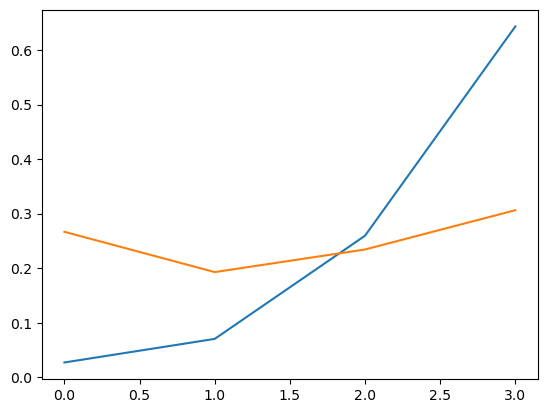

In [24]:
y_predicted_test = model.predict(X_test).argmax(axis=1)
# plt.hist(y_predicted_test,density=True)
hist = np.histogram(y_predicted_test,bins=4)[0]/np.sum(np.histogram(y_predicted_test,bins=4)[0])
hist_real = np.histogram(y_test.argmax(axis=1),bins=4)[0]/np.sum(np.histogram(y_test.argmax(axis=1),bins=4)[0])
plt.plot(hist)
plt.plot(hist_real)

In [91]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 360, 32)      320       
_________________________________________________________________
average_pooling2d (AveragePo (None, 40, 120, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 120, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 120, 64)       18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 40, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 40, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 35840)             0